<AxesSubplot:>

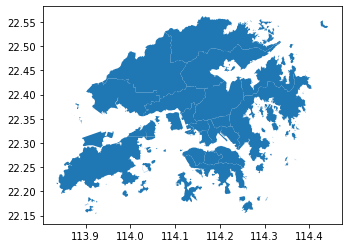

In [241]:
#import package
import pandas as pd
import numpy as np
rnd = np.random
rnd.seed(5)

#plot
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas
import geopandas as gpd
from geopy.distance import geodesic

#shapely
from shapely.geometry import Point,Polygon,shape

#read shapefile
shp = r'HKDistrict18.shp'
hk = gpd.GeoDataFrame.from_file(shp,encoding = 'utf-8')

hk.plot()

In [242]:
#randomly generate construction sites
from shapely.geometry import Point
cs_points = []
cs_seeds=45
for i in range(cs_seeds):
    cs_points.append(Point(113.835067 + rnd.rand()*(114.441993-113.835067), 22.153344+rnd.rand()*(22.561949-22.153344)))


In [243]:
# extract the construction site within the land area
cs = gpd.GeoDataFrame()
id = range(cs_seeds)
cs['id']=id
cs['geometry'] = cs_points
cs_in = cs[cs.intersects(hk.unary_union)]

In [244]:
len(cs_in)

14

In [245]:
# randomly generate the CS position
loc_x = np.array(cs_in[:]['geometry'].x)
loc_y = np.array(cs_in[:]['geometry'].y)
loc_x = np.append(0,loc_x)
loc_y = np.append(0,loc_y)

In [246]:
# potential disposal facilities
df = pd.read_csv("DF_position2.csv")
df_loc=df.to_dict('index')
df

,name,type,lat,lon
0,CW-PFBP,1,22.274430,114.261207
1,MW--PFRF,1,22.260976,114.005555
2,TM38--FB,1,22.366418,113.933980
3,NENT,3,22.538023,114.171592
4,WENT,3,22.420418,113.930554
5,CC,4,22.209003,114.028991
6,HLC,4,22.258157,114.028103
7,MaW,4,22.348195,114.055546
8,PC,4,22.284761,114.037069
9,SKW,4,22.206144,114.131527


In [247]:
loc_x = np.append(loc_x,np.array(df[:]['lon']))
loc_y = np.append(loc_y,np.array(df[:]['lat']))
len(df)

11

In [248]:
k=len(cs_in) #number of construction sites
f=len(df) #number of disposal facilities
C_site = [i for i in range(1, k+1)] #construction sites
D_fac = [i for i in range(k+1, k+f+1)] # disposal facilities
V=[0]+C_site+D_fac
# CDW quantities. (data form "Management of construction waste in public housing projects in Hong Kong." assume density=2400kg/m3(concrete) )
Q = {i: rnd.randint(5e4, 1e5) for i in C_site} 

F_type=[1,2,3,4] #facilities types
C = {1:71, 2:100, 3:150, 4:300} # treatment costs per unit
P = C # disposal costs per unit

S = {(i,j): 1e7 for i in D_fac for j in F_type } # building cost of disposal facilities

T = {(i,j): rnd.randint(0,2) for i in C_site for j in F_type}  #  if CDW can be treated by F_type 
for i in C_site:
    for j in F_type:
        if T[i,j] == 1:
            for u in range(j+1,5):
                T[i,u]=1

B = {(i,j): 1 for i in D_fac for j in F_type }  #ensure that disposal facility type f can be built in candidate location i. 
S_limit= 6e10 # upper limit on investment budget
M = 1e10  #big M

In [249]:
T

{(1, 1): 0,
 (1, 2): 0,
 (1, 3): 1,
 (1, 4): 1,
 (2, 1): 1,
 (2, 2): 1,
 (2, 3): 1,
 (2, 4): 1,
 (3, 1): 1,
 (3, 2): 1,
 (3, 3): 1,
 (3, 4): 1,
 (4, 1): 0,
 (4, 2): 1,
 (4, 3): 1,
 (4, 4): 1,
 (5, 1): 1,
 (5, 2): 1,
 (5, 3): 1,
 (5, 4): 1,
 (6, 1): 1,
 (6, 2): 1,
 (6, 3): 1,
 (6, 4): 1,
 (7, 1): 0,
 (7, 2): 0,
 (7, 3): 0,
 (7, 4): 1,
 (8, 1): 1,
 (8, 2): 1,
 (8, 3): 1,
 (8, 4): 1,
 (9, 1): 0,
 (9, 2): 1,
 (9, 3): 1,
 (9, 4): 1,
 (10, 1): 0,
 (10, 2): 1,
 (10, 3): 1,
 (10, 4): 1,
 (11, 1): 0,
 (11, 2): 0,
 (11, 3): 1,
 (11, 4): 1,
 (12, 1): 1,
 (12, 2): 1,
 (12, 3): 1,
 (12, 4): 1,
 (13, 1): 0,
 (13, 2): 0,
 (13, 3): 1,
 (13, 4): 1,
 (14, 1): 0,
 (14, 2): 1,
 (14, 3): 1,
 (14, 4): 1}

(113.84287627625422, 114.35394993079339, 22.189549955, 22.554617405)

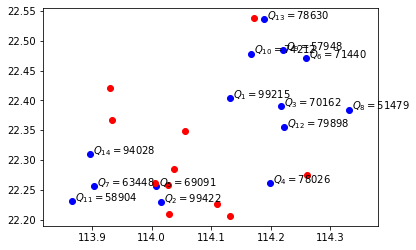

In [250]:
plt.scatter(loc_x[1:k+1], loc_y[1:k+1], c='b')
plt.scatter(loc_x[k+1:k+1+f], loc_y[k+1:k+1+f], c='r')
for i in C_site:
    plt.annotate('$Q_{%d}=%d$' % (i, Q[i]), (loc_x[i]+0.005, loc_y[i]))
plt.axis('equal')

In [251]:
#caculate the shortest distance by geographical coordinates
D = {(i, j): geodesic((loc_y[i], loc_x[i]), (loc_y[j], loc_x[j])).km for i, j in A}

In [252]:
from docplex.mp.model import Model

In [253]:
mdl = Model('CDW')

In [254]:
A = [(i, j) for i in C_site for j in D_fac]
z = mdl.binary_var_dict(A, name='z')         #(13)

F = [(i, j) for i in D_fac for j in F_type]
fac = mdl.binary_var_dict(F, name='fac')     #(9)

U = [(i, j, k) for i in C_site for j in D_fac for k in F_type]
u = mdl.binary_var_dict(U, name='u')

In [255]:
#bjective
build_cost=mdl.sum(S[i,j]*fac[i,j] for i, j in F )
trans_cost=mdl.sum(Q[i]*D[i, j]*z[i, j]+1 for i, j in A)
disposal_cost = mdl.sum(Q[i]*C[k]*u[i,j,k] for i,j,k in U)
mdl.minimize(build_cost+trans_cost+disposal_cost)
# Constraints
mdl.add_constraints(mdl.sum(fac[i, j] for j in F_type) <= 1 for i in D_fac)                              # (6)
mdl.add_constraints(fac[i,j] <= B[i,j] for i,j in F)                                                     # (7)
mdl.add(mdl.sum(S[i,j]*fac[i,j] for i, j in F ) <= S_limit)                                              # (8)
mdl.add_constraints(mdl.sum(z[i, j] for j in D_fac) == 1 for i in C_site)                                # (11)
mdl.add_constraints(z[i,j] <= mdl.sum(T[i,k]*fac[j,k] for k in F_type) for i in C_site for j in D_fac)   # (12)
mdl.add_constraints(M*(z[i,j_1]-z[i,j_2]-1) <= M*(1-mdl.sum(T[i, k]*fac[j_2, k] for k in F_type)) 
                                                + mdl.sum((D[i,j_2]+P[k])*fac[j_2,k] - (D[i,j_1]+P[k])*fac[j_1,k] for k in F_type) 
                                                for i in C_site for j_1 in D_fac for j_2 in D_fac )      # (15)
mdl.add_constraints(u[i,j,k] >= fac[j,k] + z[i,j]-1 for i,j,k in U)                                      # (19)
mdl.add_constraints(u[i,j,k] >= 0 for i,j,k in U)                                                        # (20)
#Solve
solution = mdl.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 3.4850431e+08 after 0.00 sec. (0.31 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 863 rows and 0 columns.
MIP Presolve modified 15406 coefficients.
Aggregator did 11 substitutions.
Reduced MIP has 2276 rows, 803 columns, and 16393 nonzeros.
Reduced MIP has 803 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (38.68 ticks)
Probing time = 0.00 sec. (1.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
MIP Presolve modified 7 coefficients.
Reduced MIP has 2275 rows, 803 columns, and 16384 nonzeros.
Reduced MIP has 803 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.93 ticks)
Probing changed sense of 1 constraints.
Probing time = 0.00 sec. (1.19 ticks)
Clique table members: 220.
MIP emphasis: balance optimality and feasibility.
MIP search met

In [256]:
print(solution)

solution for: CDW
objective: 1.75045e+08
z_1_18=1
z_2_23=1
z_3_23=1
z_4_22=1
z_5_23=1
z_6_23=1
z_7_16=1
z_8_23=1
z_9_22=1
z_10_22=1
z_11_18=1
z_12_23=1
z_13_18=1
z_14_22=1
fac_16_4=1
fac_18_3=1
fac_22_2=1
fac_23_1=1
u_1_18_3=1
u_2_23_1=1
u_3_23_1=1
u_4_22_2=1
u_5_23_1=1
u_6_23_1=1
u_7_16_4=1
u_8_23_1=1
u_9_22_2=1
u_10_22_2=1
u_11_18_3=1
u_12_23_1=1
u_13_18_3=1
u_14_22_2=1



In [257]:
solution.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [258]:
active_arcs = [a for a in A if z[a].solution_value > 0.9]
active_arcs

[(1, 18),
 (2, 23),
 (3, 23),
 (4, 22),
 (5, 23),
 (6, 23),
 (7, 16),
 (8, 23),
 (9, 22),
 (10, 22),
 (11, 18),
 (12, 23),
 (13, 18),
 (14, 22)]

In [259]:
fac_type = [f for f in F if fac[f].solution_value > 0.9 ]
fac_type

[(16, 4), (18, 3), (22, 2), (23, 1)]

(113.84287627625422, 114.35394993079339, 22.189549955, 22.554617405)

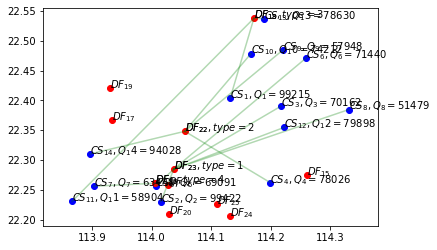

In [260]:
plt.scatter(loc_x[1:k+1], loc_y[1:k+1], c='b')
plt.scatter(loc_x[k+1:k+1+f], loc_y[k+1:k+1+f], c='r')
for i in C_site:
    plt.annotate('$CS_{%d},Q_%d=%d$' % (i, i, Q[i]), (loc_x[i], loc_y[i]))
for i in D_fac:
    plt.annotate('$DF_{%d}$' % (i), (loc_x[i], loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
for i, j in fac_type:
    plt.annotate('$DF_{%d},type=%d$' % (i, j), (loc_x[i], loc_y[i]))
plt.axis('equal')

In [261]:
fac_type

[(16, 4), (18, 3), (22, 2), (23, 1)]

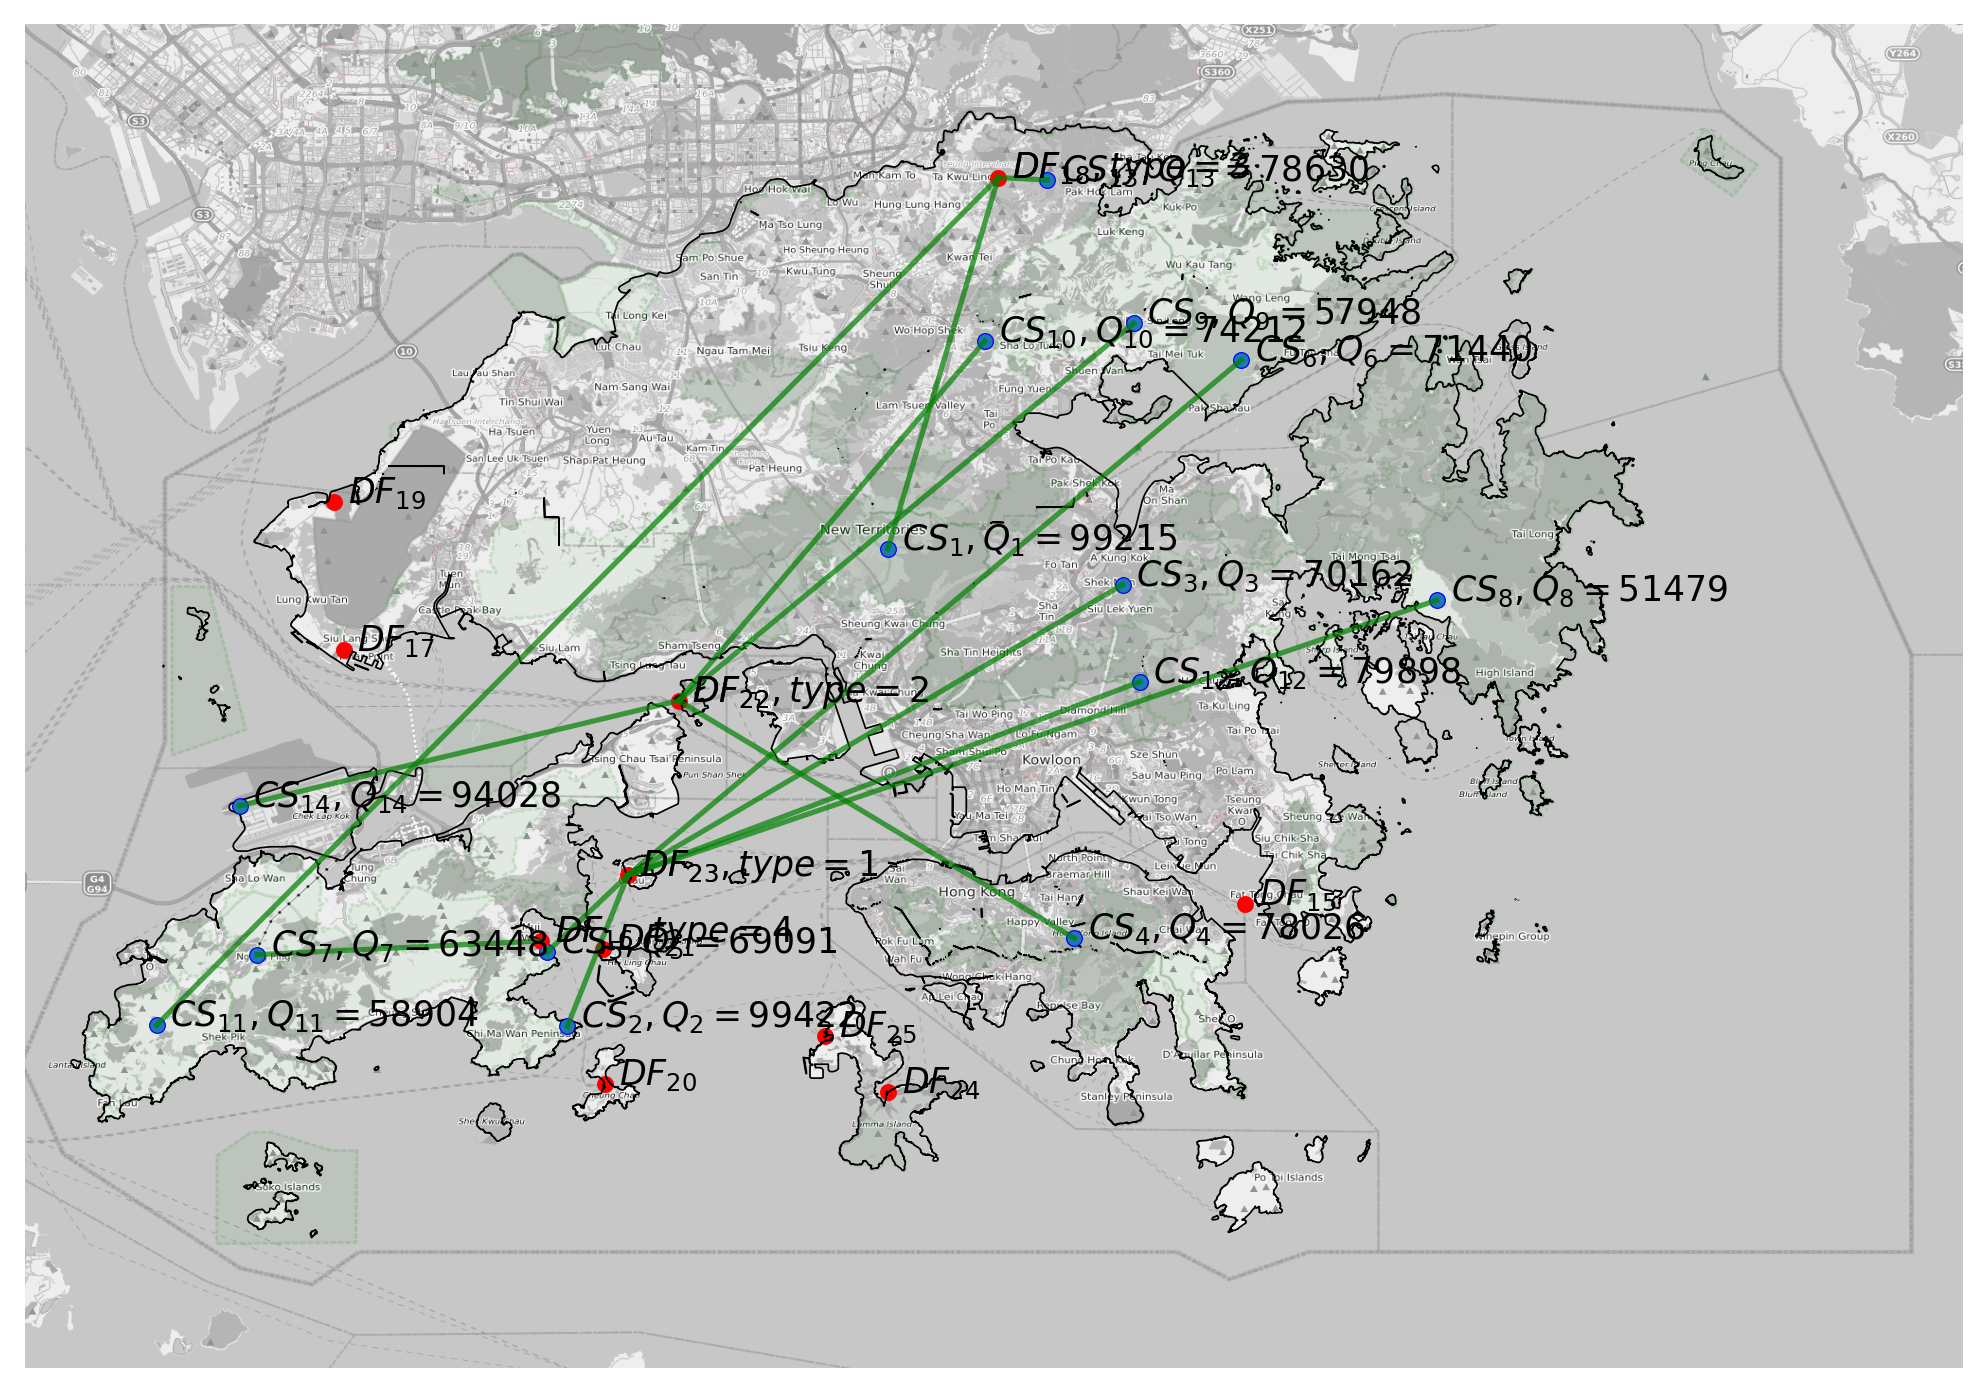

In [262]:
import plot_map
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
plt.scatter(loc_x[1:k+1], loc_y[1:k+1], c='b',s = 15)
plt.scatter(loc_x[k+1:k+1+f], loc_y[k+1:k+1+f], c='r',s = 15)
for i in C_site:
    plt.annotate('$CS_{%d},Q_{%d}=%d$' % (i, i, Q[i]), (loc_x[i]+0.005, loc_y[i]))
for i in D_fac:
    plt.annotate('$DF_{%d}$' % (i), (loc_x[i]+0.005, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.7)
for i, j in fac_type:
    plt.annotate('$DF_{%d},type=%d$' % (i, j), (loc_x[i]+0.005, loc_y[i]))

hk_all = gpd.GeoDataFrame()
hk_all['geometry'] = [hk.unary_union]
hk_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
cs_in.plot(ax = ax,markersize=10)

bounds = [113.835067,22.153344,114.441993, 22.561949]
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

plt.axis('off')  
plt.show()